## Task 0 (Know your Data) - Exploratory Data Analysis

## 0.1. Loading Data

In [675]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import neighbors, tree, preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
import re

def int_encode_class(vect):
    enc = LabelEncoder()
    label_encoder = enc.fit(vect)
    integer_classes = label_encoder.transform(label_encoder.classes_)
    t = label_encoder.transform(vect)
    return t
    
def int_encode_feature(vect):
    return int_encode_class(vect)

In [676]:
df = pd.read_csv('PetFinder_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

Loading colour, breed and state labels:

In [677]:
color_labels = pd.read_csv('color_labels.csv').set_index('ColorID')
breed_labels = pd.read_csv('breed_labels.csv').set_index('BreedID')
state_labels = pd.read_csv('state_labels.csv').set_index('StateID')

## 0.2. Understanding Data

### Basic Questions

#### How big is the dataset?
The dataset contains 14993 entries with 24 features each.

#### Is this the entire dataset?
The original dataset from PetFinder.my contains over 150,000 animal profiles.

#### Is this data representative enough?
The dataset represents ~10% of the original data. EDA is required to best assess whether it can be considered a representative sample of the original population.

#### Are there likely to be gross outliers or extraordinary sources of noise?
EDA can shed light on this topic, by representing data distribution and irregularities that could point to errors in data.

#### Are there any fields that are unique identifiers? These are the fields you might use for joining between datasets, etc.
All animal profiles are uniquely identified by a PetID. Each PetID also has a non-unique RescuerID, and a non-unique State.

#### Are the supposedly unique identifiers actually unique? What does it mean if they aren't?
PetID.

#### When data entries are blank, where does that come from?
The only blank entries in this dataset correspond to animal profiles without an assigned name.

#### How common are blank entries?
There are ~1200 blank entries, which constitute a significant portion of the data. Given this number, and due to the fact that blank entries have meaning attributed to them, it would perhaps be best to keep this data in the dataset for analysis.

## Exploratory Data Analysis

In order to better understand our dataset and to make decisions about feature selection, feature extraction and general cleaning of the data, we started by plotting distribution of the original features and the target.

### Target: *AdoptionSpeed*

The target feature displayed a clear discrepancy in distribution, showing a significantly lower number of examples for AdoptionSpeed = 0. This imbalance should be addressed, as models tend to neglect minority classes if they don't have a large enough representation in the overall dataset, therefore compromising the classification.

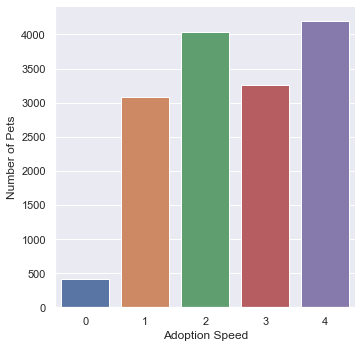

In [678]:
ax = sns.catplot(x="AdoptionSpeed",data=df, kind='count')
(ax.set_axis_labels("Adoption Speed", "Number of Pets"))

### Overall correlations
The plot bellow illustrates the absolute correlation between  each feature and the target class "AdoptionSpeed". All correlations are very low (<15%)

([<matplotlib.axis.XTick at 0x1a25d3c190>,
 <a list of 19 Text xticklabel objects>)

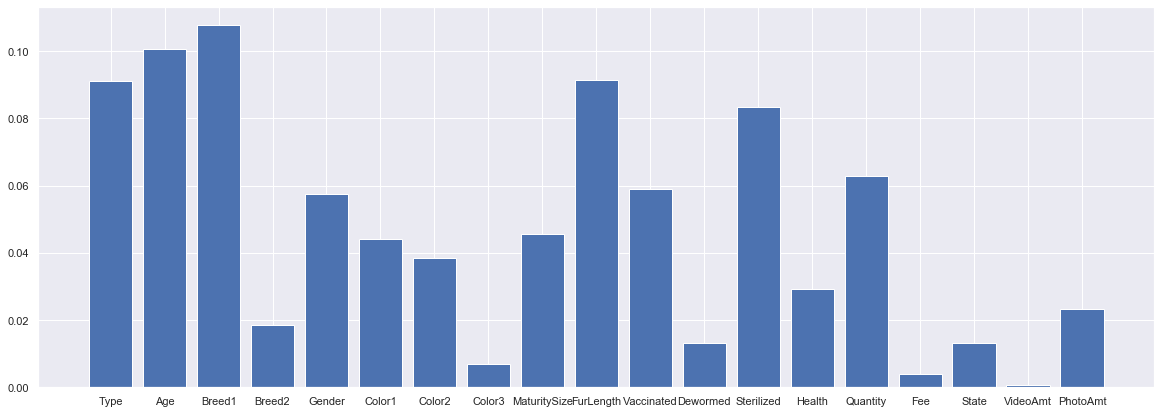

In [679]:
numeric_df = df.select_dtypes(exclude=['object'])
corr_dict = {}
for feature in numeric_df.columns:
    corr_dict[feature] = abs(df['AdoptionSpeed'].corr(df[feature]))
    #print(feature, '-->', corr_dict[feature])
    
corr_dict.pop('AdoptionSpeed')
plt.figure(figsize=(20,7))
plt.bar(range(len(corr_dict)), list(corr_dict.values()), align='center')
plt.xticks(range(len(corr_dict)), list(corr_dict.keys()))

### PetID

Since PetID is not informative of the pet profile (it acts solely as a unique identifier of the page), it would be excluded from the analysis, although it will be used as an index for the dataFrame. It can be later useful when evaluating model performance, as the respective record values can reveal if certain features were appropriately categorised.

In [680]:
df.set_index("PetID", inplace=True) # change index to PetId
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,Nibble,3,299,0,1,1,7,0,1,...,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,1.0,2
6296e909a,2,No Name Yet,1,265,0,1,1,2,0,2,...,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,2.0,0
3422e4906,1,Brisco,1,307,0,1,2,7,0,2,...,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,7.0,3
5842f1ff5,1,Miko,4,307,0,2,1,2,0,2,...,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",8.0,2
850a43f90,1,Hunter,1,307,0,1,1,0,0,2,...,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,3.0,2


### Type

Because we are going to later create type-specific predictive models, it would be relevant to see the number of cases we have in our dataset for each animal (cat or dog).

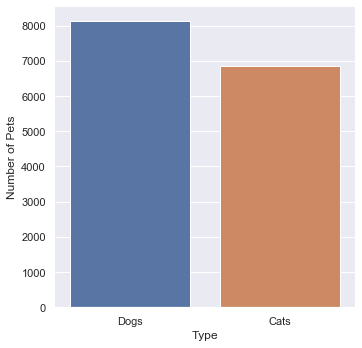

In [681]:
bx = sns.catplot(x="Type",data=df, kind='count')
(bx.set_axis_labels("Type", "Number of Pets")
    .set_xticklabels(["Dogs", "Cats"])
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

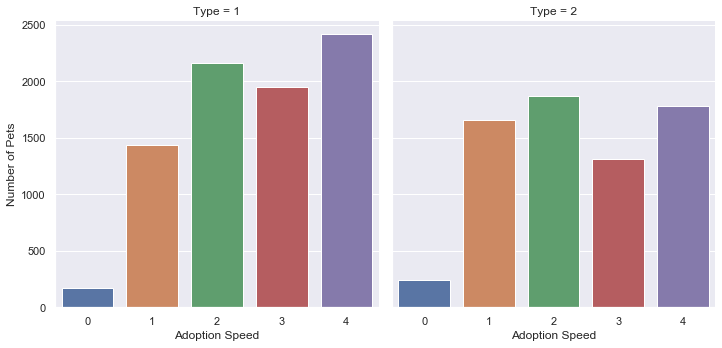

In [682]:
cx = sns.catplot(x="AdoptionSpeed",col="Type",data=df, kind='count')
(cx.set_axis_labels("Adoption Speed", "Number of Pets"))

Looking at our data, we conclude the number of examples is fairly proportional, as well as their distribution relative to the target class, making the resulting models' performance more comparable.

### Name
Since a reasonable amount of the profiles didn't make any reference to name (empty) a first approach would be to fill those empty values with a fixed value such as "No Name" or similar.
Other approach would be to transform this feature into a binary one with a 0 value for profiles with no name and a 1 value for the opposite.
Since it was later found that some of the named profiles were filled with "No Name" and derivatives of this name such as "No Name Yet", "V6", "å°è±¹çº¹" etc., which are not proper names, we made an attempt to classify those cases as "No name" as well.

A glimpse on the ignored names: ['No Name Yet', 'No Name', 'No Name', 'H3', 'Z3', 'C', 'No Name', 'No Name', 'BB', 'QQ', 'Y1', 'No Name', 'H1', 'No Name Yet', 'D9', 'Y4', 'No Name', 'Z4', 'No Name', 'Unnamed', 'BB', 'DD', 'M2', 'H6', 'D4', 'QQ', 'JJ', 'No Names', 'å°\x8fè±¹çº¹', 'ä¼\x98ç¾\x8eå\x8f¯ç¬\x91', 'F1', 'æ©\x98å\xad\x90', 'W7', '(No Name)', 'No Name Yet', 'No Name', '1F', 'Q1', '6', 'CJ', '3F', '[No Name]', 'BB', 'KD', 'No Name Yet', 'No Name Yet', 'DD', 'No Name', 'G1', 'è\x8f\x9cè\x8f\x9cã\x80\x82']


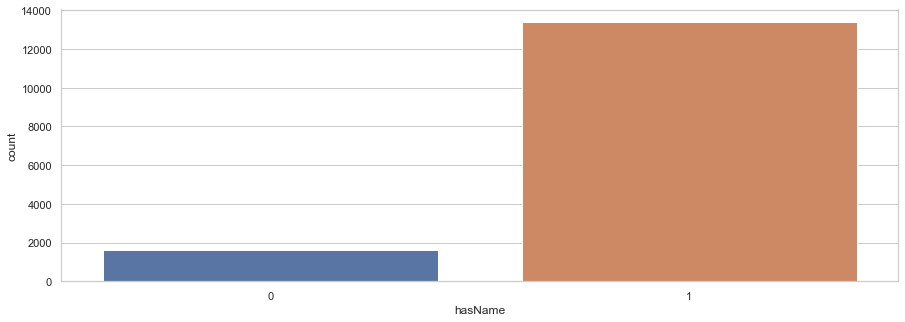

In [683]:
# Create new feature - hasNames
l = []
ignore = []

for i in df["Name"]:
    if type(i)!=str: # Some empty descriptions are type:float
        l.append(0)
        count+=1
    else:
        if len(i)<3: #Consider that a 2 letter name is not a proper name.
            l.append(0)
            ignore.append(i)
        elif re.search("[a-zA-Z]", i) == None: #If name doesn't have letters, it's not a proper name.
            l.append(0)
            ignore.append(i)
        elif re.search("unnamed|no name",i, re.IGNORECASE) != None: 
            #If name string includes "unnamed" or "no name", it's not a proper name
            l.append(0)
            ignore.append(i)
        elif len(i.split())>0:
            l.append(1)

print("A glimpse on the ignored names:",ignore[:50])
df_processed = df.copy()
df_processed.drop("Name", axis=1, inplace = True)
df_processed.insert(1,"hasName",l) ##INSERT IN DATAFRAME

sns.set(style="whitegrid")
ax = sns.countplot(x="hasName", data=df_processed)

#### Useful visualisation tool:

In [684]:
# creates a stacked bar plot for any two categorical variables
# also creates a relative frequency version of the same plot
# and a relative gain compared to AdoptionSpeed=0 
# frel=False to return only the absolute frequency plot

def cat_distr_pairwise(cat_x,cat_y, df, frel):
    
    unique_cat_y = sorted(df[cat_y].unique())
    unique_cat_x = sorted(df[cat_x].unique())
    cat_count = pd.DataFrame(columns=unique_cat_y,index=unique_cat_x)
    for y in unique_cat_y:
        for x in unique_cat_x:
            count = df[cat_y][(df[cat_x]==x) & (df[cat_y]==y)].count()
            cat_count.at[x,y] = count 
    
    def color(val):
        if val < 0:
            color = 'red'
        elif val>0:
            color = 'green'
        else:
            color='white'
        return 'background-color: %s' % color
    
    if frel==False:
        
        #relative gain table
        relgain = cat_count.pct_change().cumsum() * 100
        print("Relative gain from AdoptionSpeed=0 (%):")
        display(relgain.style.applymap(color))
        return cat_count.plot.bar(stacked=True, figsize=(10,7))
    
    else:
        #relative frequency stacked bar plot
        freq_cat_count = cat_count.divide(cat_count.sum(axis=1), axis=0)
        
        #relative gain table
        relgain = freq_cat_count.pct_change().cumsum() * 100
        print("Relative gain from AdoptionSpeed=0 (%):")
        display(relgain.style.applymap(color))

        return freq_cat_count.plot.bar(stacked=True, figsize=(10,7))
    

Relative gain from AdoptionSpeed=0 (%):


,0,1
0,nan,nan
1,28.3828,-2.81545
2,14.3321,-0.974261
3,9.85559,-0.479193
4,38.1045,-3.44873


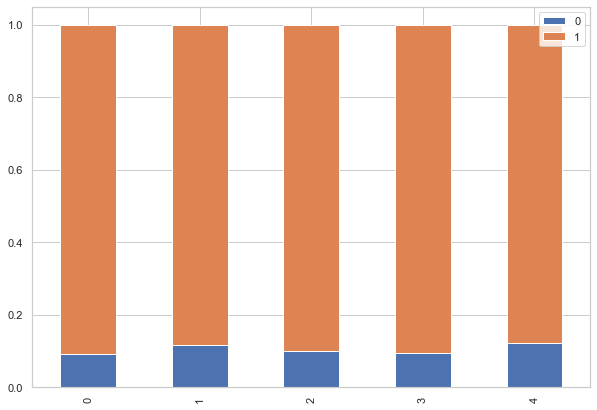

In [685]:
cat_distr_pairwise('AdoptionSpeed','hasName', df_processed, frel=True)

As we can see from the plot above, the relative distribution of the "noName" among "AdoptionSpeed" classes is very similar. This probabably means that the pet's name is not a very important factor in the adopter's decision.

### Age

When looking at the Age distribution, we can see that there are peaks every 12 months. Young pets (less than 1 year old) are the most frequent.

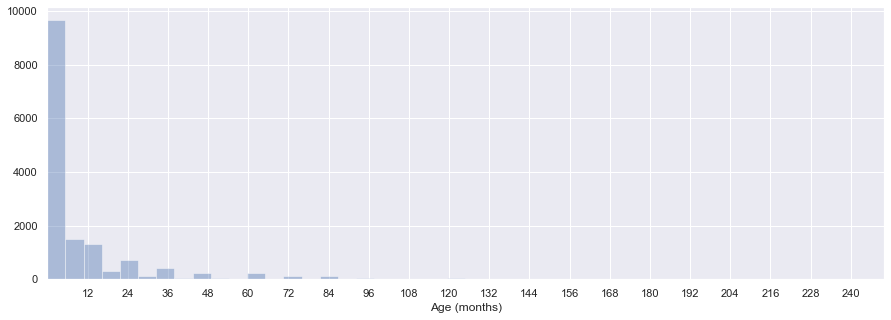

In [686]:
a = df['Age'] # get Age array
nr_bins = 1 + 3.322*math.log(len(a),2) # Number of bins according to Sturges rule
sns.set(rc={'figure.figsize':(15,5)}) # set figure size

# setting up the axis
fig, ax = plt.subplots()
ticks = [i for i in range(0,260,12)]
ticks.pop(0)
ax.set_xticks(ticks)
plt.xlim([0.0,250])

sns.distplot(a, bins=round(nr_bins), kde=False, axlabel="Age (months)");

The average cat is considered a kitten roughly until it reaches the age of 1 year old. The same goes for puppies. On the other hand, dogs and cats are considered Seniors roughly when they reach the age of 6 years. Of course, these are approximations, as the classification varies with the type of animal (cats or dogs), breed, size and many other factors.

In this sense, we will consider these categories:
* Baby - age 0-11 months => 0
* Adult - age 12-71 months =>1
* Senior - age 72-250 months =>2

In [687]:
# Create new feature - AgeGroup
AgeGroup = []
for i in df["Age"]:
    if i<12:
        AgeGroup.append(0)
    elif i<72:
        AgeGroup.append(1)
    else:
        AgeGroup.append(2)

df_processed.drop("Age", axis=1, inplace = True)
df_processed.insert(2,"AgeGroup",AgeGroup) ##INSERT IN DATAFRAME

Relative gain from AdoptionSpeed=0 (%):


,0,1,2
0,nan,nan,nan
1,11.4206,-27.3511,-52.4542
2,11.9318,-35.1685,18.4303
3,7.09603,-14.0861,37.1413
4,-10.7473,54.0975,42.645


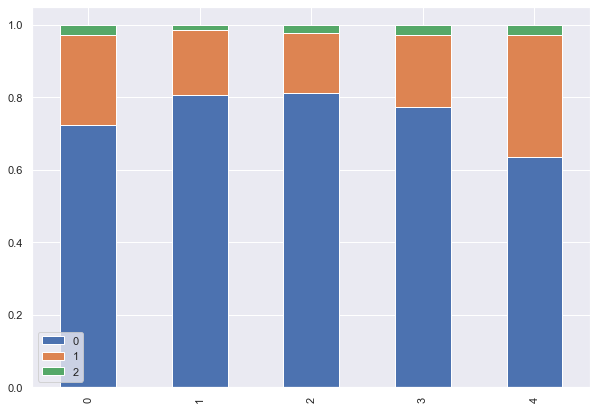

In [688]:
cat_distr_pairwise('AdoptionSpeed','AgeGroup', df_processed, frel=True)

The relative distribution of AgeGroups among AdoptionSpeed indicates that there seems to be no particular correlation between being younger and getting adopted earlier. Even without the dicretization we can observe the same phenomena: 

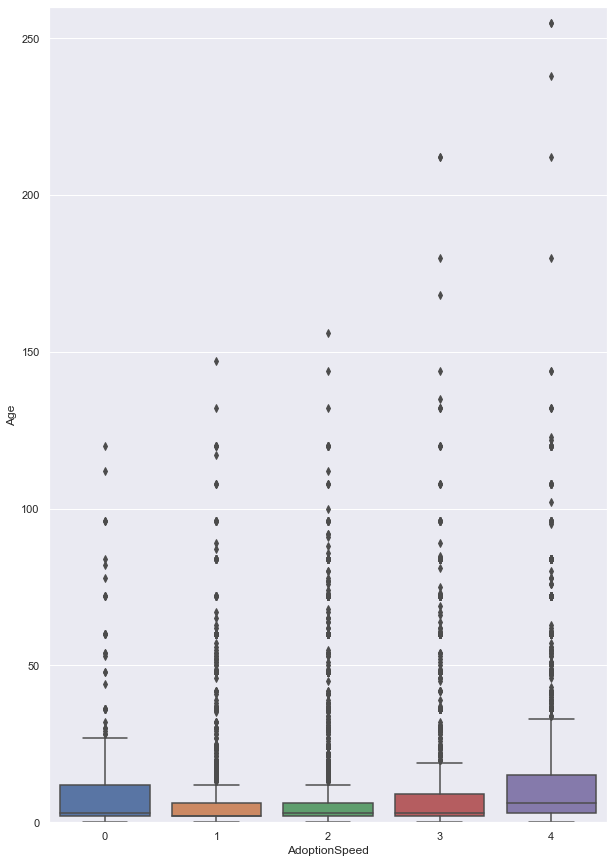

In [689]:
plt.figure(figsize=(10,15))
plt.ylim(0, 260)
sns.boxplot(data = df, x='AdoptionSpeed', y='Age')

### Breed1 and Breed2

According to the breeds feature labels, dogs breeds go from 1 to 240, plus 307, and cats breeds go from 241 to 306. 

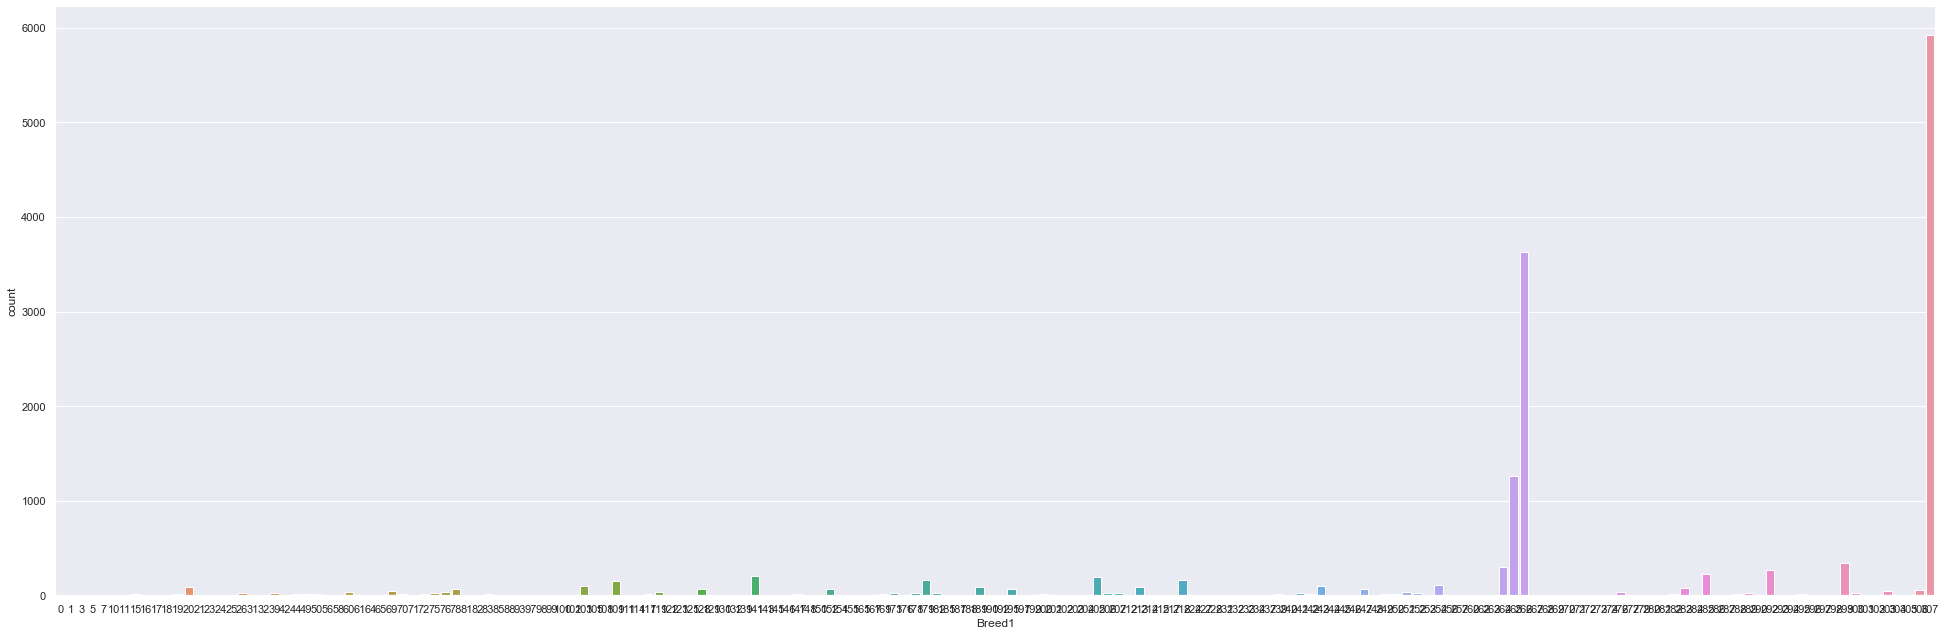

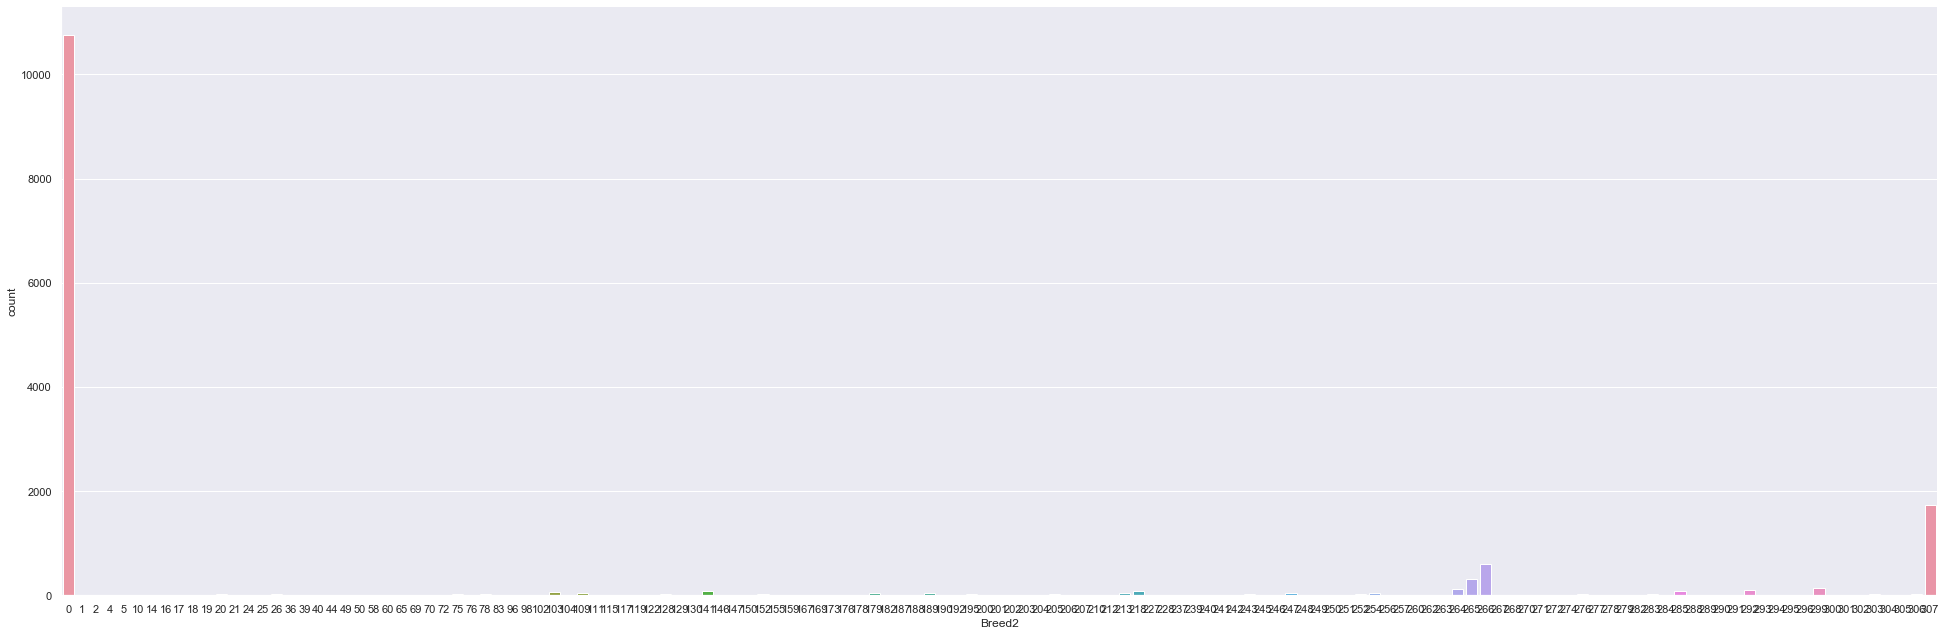

In [690]:
bx1 = sns.catplot(x="Breed1",data=df, kind='count',height=9, aspect=3)
bx2 = sns.catplot(x="Breed2",data=df, kind='count',height=9, aspect=3)

Looking at our data, and according to the breeds feature labels, we found some cats with dogs breeds assigned to them (15, 21, 25, 70, 114, 205, 218, 307).
Therefore, and given the distribution of pets by breeds in which some breeds are poorly representated perhaps a good idea should be grouping pets by pure-race/mixed-race.

In [691]:
#Creating new feature: Pure breed
l3 =[]
for i in range(len(df)):
    if df['Breed1'][i]==307 or df['Breed2'][i]==307:
        l3.append(0)
    elif df['Breed1'][i]!=307 and df['Breed2'][i]==0:
        l3.append(1)
    elif df['Breed1'][i]==0 and df['Breed2'][i]!=307:
        l3.append(1)
    elif df['Breed1'][i]==df['Breed2'][i]:
        l3.append(1)
    else:
        l3.append(0)
        
df_processed.drop("Breed1",axis=1,inplace=True)
df_processed.drop("Breed2",axis=1,inplace=True) 
df_processed.insert(3,'PureBreed',l3) ##INSERT IN DATAFRAME

Relative gain from AdoptionSpeed=0 (%):


,0,1
0,nan,nan
1,-3.85362,3.49515
2,15.5367,-12.8427
3,25.9202,-25.3278
4,23.972,-22.3732


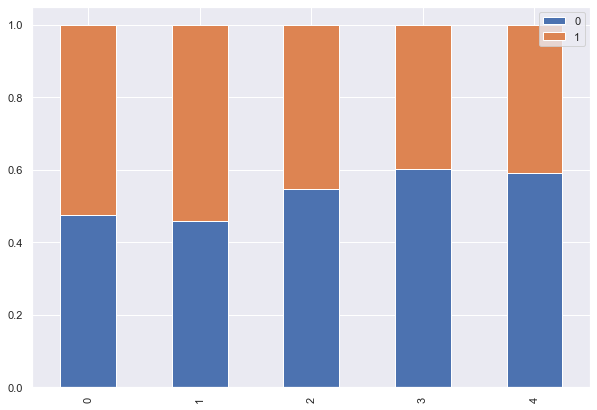

In [692]:
cat_distr_pairwise('AdoptionSpeed','PureBreed', df_processed, frel=True)

### Gender

Relative gain from AdoptionSpeed=0 (%):


,1,2,3
0,nan,nan,nan
1,6.39765,-11.1524,27.2056
2,0.538928,-4.07202,22.319
3,-12.405,4.24336,30.5943
4,-13.9588,2.99126,38.5595


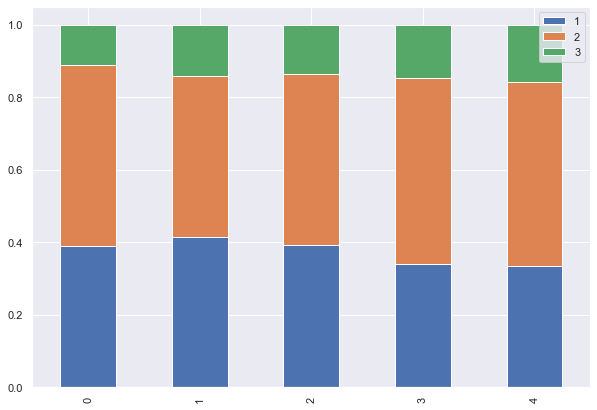

In [693]:
gender = cat_distr_pairwise('AdoptionSpeed','Gender', df, frel=True)

### Color1, Color2 and Color3

Each pet has at least one main color (color1) that according to the colors features label can go from black(1) to white(7). Pets can also have one or two additional colors (color2 and color3) with the same categorical values as the main color.

Relative gain from AdoptionSpeed=0 (%):


,1,2,3,4,5,6,7
0,nan,nan,nan,nan,nan,nan,nan
1,14.8923,-23.1759,-3.45944,42.8927,-14.1443,-28.624,79.6365
2,18.924,-16.9725,-0.0733397,22.1683,-31.3398,-32.9466,58.7879
3,18.2775,-6.31663,-20.0996,46.0407,-35.0525,-48.4593,43.8651
4,17.5163,-3.38853,-19.6601,48.3254,-48.1676,-48.6226,50.0912


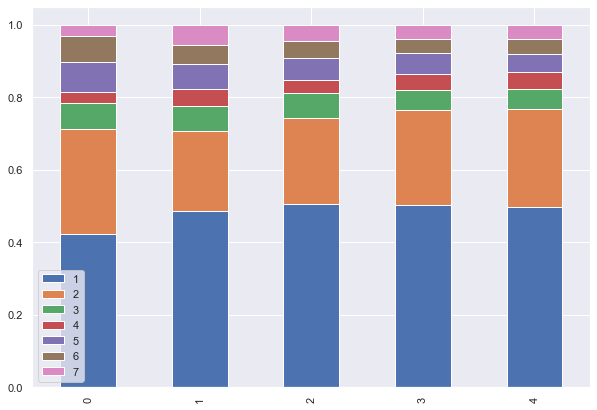

In [694]:
#zx1 = sns.catplot(x="Color1",col="Type",data=df, kind='count',height=4, aspect=0.8)
#(zx1.set_axis_labels("Color 1", "Number of Pets"))
#zx2 = sns.catplot(x="Color2",col="Type",data=df, kind='count',height=4, aspect=0.8)
#(zx2.set_axis_labels("Color 2", "Number of Pets"))
#zx3 = sns.catplot(x="Color3",col="Type",data=df, kind='count',height=4, aspect=0.8)
#(zx3.set_axis_labels("Color 3", "Number of Pets"))

color1= cat_distr_pairwise('AdoptionSpeed','Color1', df, frel=True)

Relative gain from AdoptionSpeed=0 (%):


,0,2,3,4,5,6,7
0,nan,nan,nan,nan,nan,nan,nan
1,8.99214,0.0121359,31.8568,19.4175,-26.8684,-19.7712,1.41008
2,4.83602,19.8391,16.5825,33.758,-24.8124,-35.575,-4.47087
3,6.01995,19.698,27.0823,22.8232,-30.7321,-46.7854,0.57181
4,17.091,14.0829,26.9896,45.1008,-36.2571,-44.8925,-11.0396


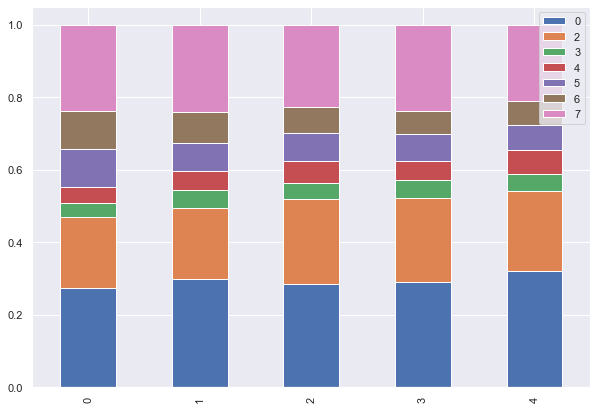

In [695]:
color2 = cat_distr_pairwise('AdoptionSpeed','Color2', df, frel=True)

Relative gain from AdoptionSpeed=0 (%):


,0,3,4,5,6,7
0,nan,nan,nan,nan,nan,nan
1,6.00359,76.9148,-23.0421,-12.4272,11.4563,-16.3949
2,5.5886,55.3703,3.64811,-39.751,16.2459,-11.3118
3,7.23526,58.0937,9.45575,-15.8786,-4.0449,-16.913
4,5.45326,88.2728,51.4997,-20.8804,-4.35819,-14.103


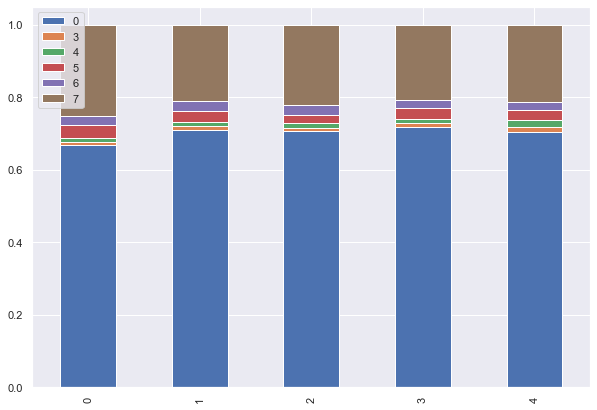

In [696]:
color3 = cat_distr_pairwise('AdoptionSpeed','Color3', df, frel=True)

Given the number of values for each color feature one of the following approaches should be appropriate to address the Color1, Color2 and Color3 features: 
* Group pets according to the number of colors one has. Pets with only one color will be assigned a "SingleColor" feature and so on;
* Group colours according to their brightness/darkness.

However we will leave further considerations on the feature engineering part later on this document.

### Maturity Size

Relative gain from AdoptionSpeed=0 (%):


,1,2,3,4
0,nan,nan,nan,nan
1,-16.9519,12.0786,-6.19402,-53.5599
2,-39.1782,25.8291,-29.4003,-33.2796
3,-49.3567,28.8741,-28.6778,-20.6684
4,-45.0552,26.6943,-15.9591,-97.3732


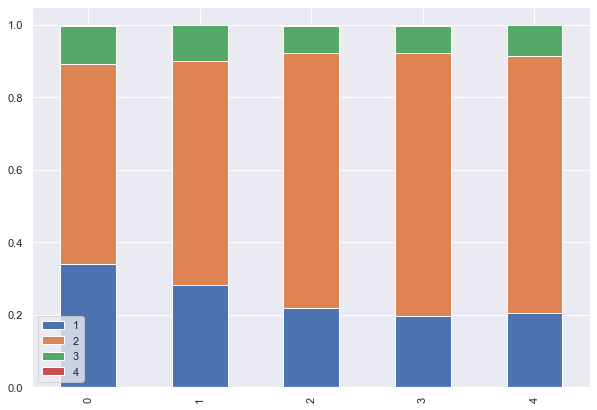

In [697]:
size = cat_distr_pairwise('AdoptionSpeed','MaturitySize', df, frel=True)

### Fur Length

Relative gain from AdoptionSpeed=0 (%):


,1,2,3
0,nan,nan,nan
1,12.7832,-1.56351,-39.8174
2,22.8848,-8.44925,-73.2198
3,27.017,-13.143,-86.9015
4,28.2277,-11.1697,-116.814


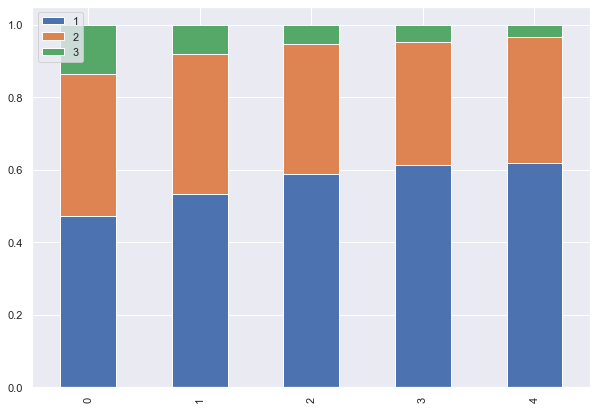

In [698]:
fur = cat_distr_pairwise('AdoptionSpeed','FurLength', df, frel=True)

### Vaccinatted, Dewormed and Sterilized

XXXXXXXXX

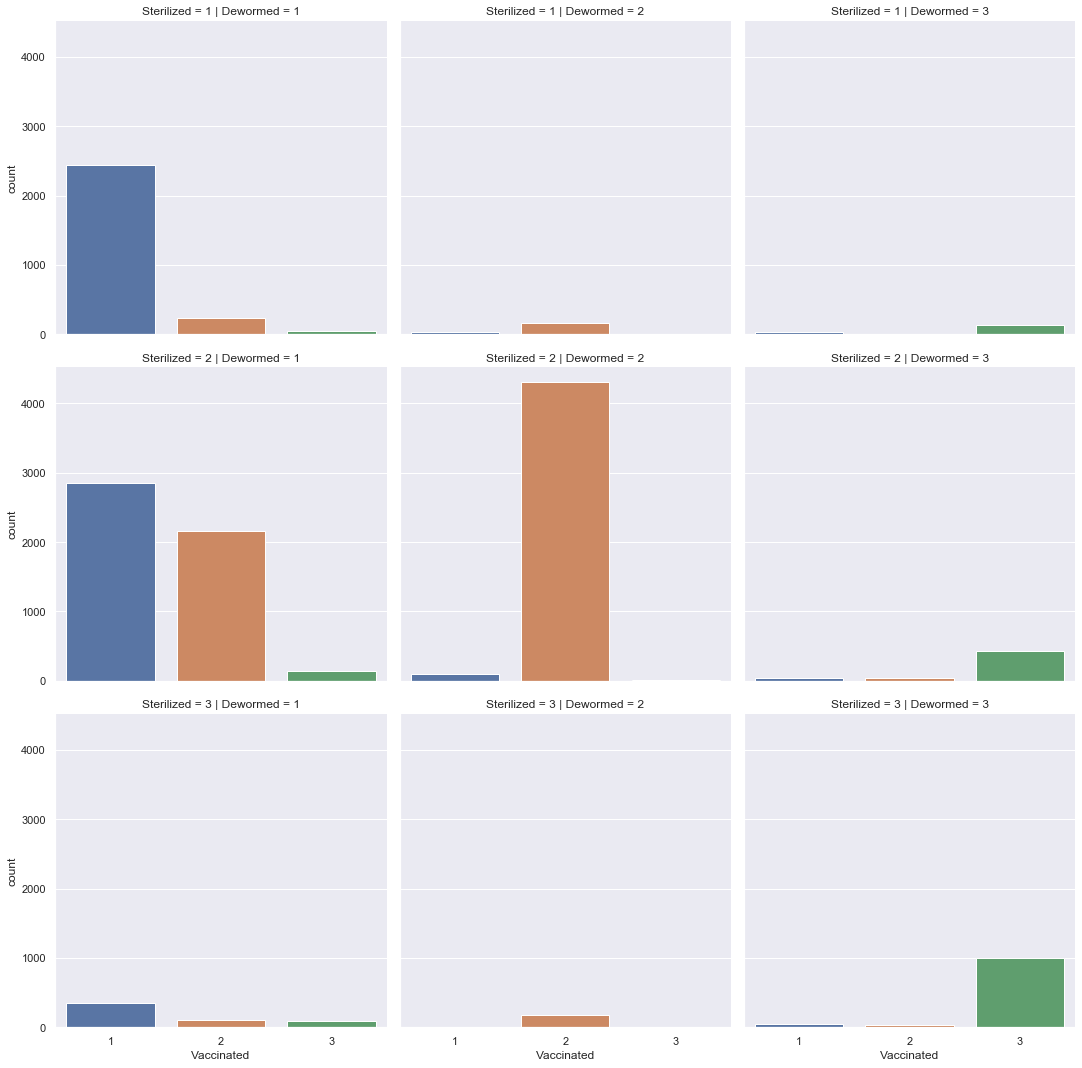

In [699]:
ax11 = sns.catplot(x='Vaccinated', col='Dewormed',row='Sterilized',data=df, kind='count')

Relative gain from AdoptionSpeed=0 (%):


,1,2,3
0,nan,nan,nan
1,-12.3,14.4579,-20.3883
2,4.53564,5.42953,-20.9717
3,23.8668,-8.99766,-16.5572
4,27.5653,-19.9575,11.6378


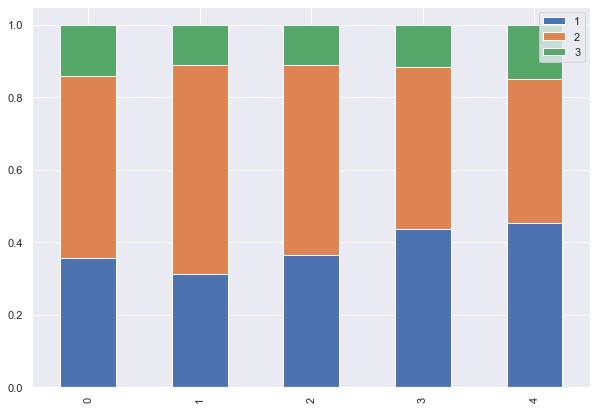

In [700]:
vac = cat_distr_pairwise('AdoptionSpeed','Vaccinated', df, frel=True)

Relative gain from AdoptionSpeed=0 (%):


,1,2,3
0,nan,nan,nan
1,1.74757,7.96648,-25.7857
2,12.4218,-5.24727,-29.0645
3,20.7625,-21.1943,-23.0155
4,12.9043,-17.5468,11.405


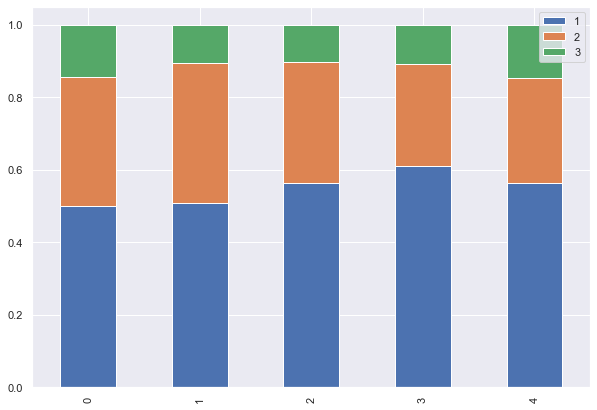

In [701]:
dew = cat_distr_pairwise('AdoptionSpeed','Dewormed', df, frel=True)

Relative gain from AdoptionSpeed=0 (%):


,1,2,3
0,nan,nan,nan
1,-31.0032,16.862,-34.0361
2,6.94056,14.1328,-55.0746
3,42.898,6.40172,-55.7007
4,82.13,-19.2247,46.5146


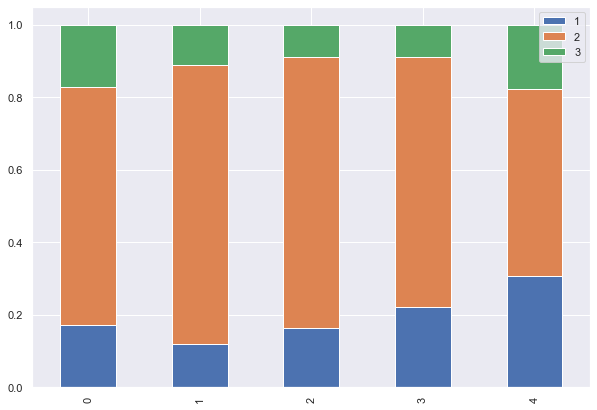

In [702]:
ste = cat_distr_pairwise('AdoptionSpeed','Sterilized', df, frel=True)

### Health

Relative gain from AdoptionSpeed=0 (%):


,1,2,3
0,nan,nan,nan
1,1.51162,-30.5349,-73.4628
2,1.68745,-39.3726,56.1632
3,1.10093,-24.8491,183.262
4,0.000809001,10.6435,182.091


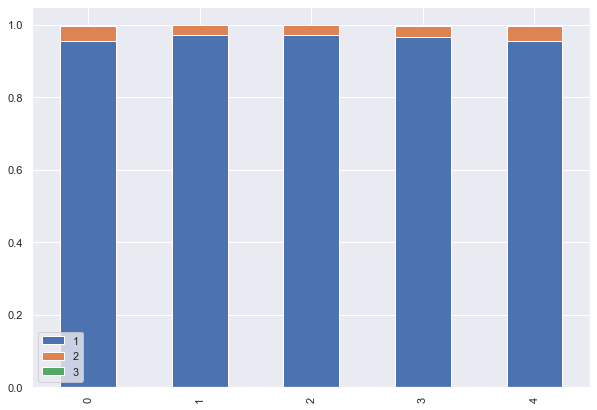

In [703]:
h = cat_distr_pairwise('AdoptionSpeed','Health', df, frel=True)

### Quantity

There are 11565 profiles with a single pet
There are 3428 profiles with multiple pets


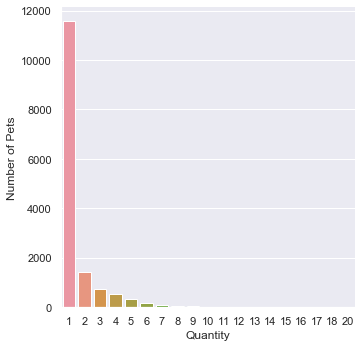

In [704]:
ax3 = sns.catplot(x='Quantity', data=df, kind='count')
(ax3.set_axis_labels("Quantity", "Number of Pets"))
print('There are {} profiles with a single pet'.format((list(df['Quantity'])).count(1)))
print('There are {} profiles with multiple pets'.format(len(df['Quantity'])-list(list(df['Quantity'])).count(1)))

Relative gain from AdoptionSpeed=0 (%):


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,-2.2292,9.9399,4.82201,8.19019,-20.3883,284.79,inf,-53.5599,inf,-73.4628,nan,nan,nan,nan,inf,nan,nan,nan,inf
2,-2.96626,5.48541,-7.49382,1.34035,43.6302,319.398,inf,10.4587,inf,-58.6498,inf,inf,inf,nan,inf,inf,inf,nan,inf
3,-3.02246,10.5374,-6.20593,-5.51533,33.0936,311.695,inf,9.55656,inf,-76.0682,inf,inf,inf,nan,inf,inf,inf,nan,inf
4,-9.30609,18.7931,8.69613,43.3819,87.2003,346.562,inf,13.0908,inf,251.011,inf,inf,inf,inf,inf,inf,inf,inf,inf


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,,
76358e754,1,Puppy Super Mix,2,307,0,3,1,7,0,2,...,2,1,11,0,41326,561c42b6c0f1ec28fba5781efe78d5c7,0,A female mix breed appear around my home few m...,8.0,2
b03c17502,1,NaN,1,307,0,3,1,2,7,2,...,3,1,11,0,41336,5d9d6838cb00440c65d0475ccc464aa1,0,Help to adopt this dogs. They are by road side,1.0,2
12a280806,1,Father Day 11 Puppies,1,307,307,2,1,2,7,2,...,3,1,11,0,41401,dc2fe1050f6811d4877bbbc340fe9d78,0,Looking forever home,11.0,4
a85630773,1,New Born Cutties For Adoption,1,307,0,3,1,2,0,2,...,2,1,11,0,41401,719c8e0d138a42d6926b483a8429d7cb,0,My street friends have 11 new born puppies. Th...,5.0,4
f90722a00,2,NaN,2,264,0,3,3,5,6,2,...,2,1,11,30,41326,232b1c56ed1c7c38753b91e97a390ac7,0,I have 9 kittens and 2 adult mother cat. Very ...,6.0,4
10124968c,1,Sunway 17 Puppies,2,307,0,3,1,2,7,2,...,2,1,11,0,41401,ee2747ce26468ec44c7194e7d1d9dad9,0,These 11 puppies were rescued from a Sunway de...,29.0,4
f8710e158,1,A To L,2,307,0,3,1,2,7,2,...,2,1,11,0,41326,aa66486163b6cbc25ea62a34b11c9b91,0,A to L are 11 adorable siblings looking for lo...,21.0,3
d277a0abd,2,Cute Kittens Of Varying Ages,1,266,0,3,1,6,7,2,...,3,1,11,0,41401,a0846c4e33807fc011de2ca5dc2b6250,0,Eleven sweet & cute kittens of varying ages fo...,5.0,4
574e7393b,2,2 Stray Female Cats N 9 Kitties,1,299,0,3,1,2,5,1,...,3,1,11,0,41401,23601adcdcacc154076d9216eb7fbb9c,0,I found 2 mama stray cats with her litter of 9...,0.0,4


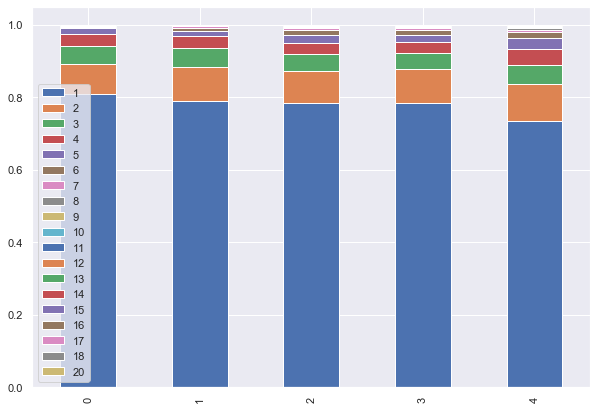

In [705]:
ste = cat_distr_pairwise('AdoptionSpeed','Quantity', df, frel=True)
df.loc[df['Quantity'] == 11]

It seems that adds with more than 6 pets are less likely to be adopted fast (brown bar).

### Fee

Let us consider paid vs free

In [706]:
f=[]
for i in df["Fee"]:
    if i==0:
        f.append(0)
    elif i<100:
        f.append(1)
    elif i<1000:
        f.append(2)
    else:
        f.append(3)

#df_processed.drop("Free",axis=1,inplace=True) 
df_processed.insert(4,'Free',f) ##INSERT IN DATAFRAME

Relative gain from AdoptionSpeed=0 (%):


,0,1,2,3
0,nan,nan,nan,nan
1,-2.95704,50.5987,3.661,-73.4628
2,-2.40591,45.0117,3.16559,-96.9208
3,-1.68287,41.4552,-1.16684,-134.985
4,-4.90487,54.3693,23.8168,-234.985


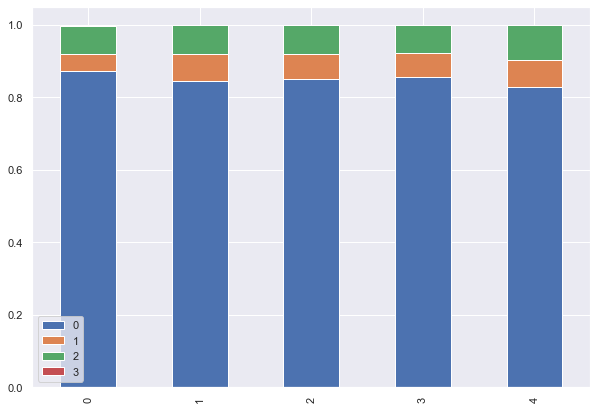

In [707]:
fee = cat_distr_pairwise('AdoptionSpeed','Free', df_processed, frel=True)

According to the dataset, the number of rescuers with a single entry in the MyPet webpage is greater than the number of rescuers who save and advertise more than 1 pet. This information could be useful on later anaylsis to discover whether the number of webpage profile entries associated with a rescuer has any interference in pet's apoption or adoption speed.

### State

XXXXXXXXX

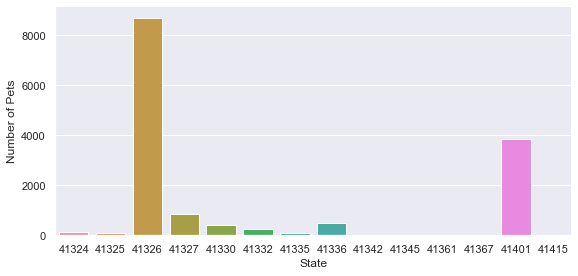

In [708]:
ax13 = sns.catplot(x='State', data=df, kind='count',height=4, aspect=2)
(ax13.set_axis_labels("State", "Number of Pets"))

Relative gain from AdoptionSpeed=0 (%):


,41324,41325,41326,41327,41330,41332,41335,41336,41342,41345,41361,41367,41401,41415
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,-40.2913,-38.0798,1.24056,102.346,112.298,19.4175,28.2632,-34.8107,-86.7314,-20.3883,inf,-80.0971,-3.56565,nan
2,-42.4876,47.8079,0.537171,137.863,189.301,53.366,-34.7855,-42.6894,-186.731,-82.1174,inf,-103.555,-9.90985,inf
3,-77.8586,31.6039,2.48386,150.839,219.869,35.9475,6.78292,-48.8743,inf,-16.9542,inf,-162.264,-18.9955,inf
4,339.813,53.1441,-14.1308,169.089,213.448,135.621,18.4058,-49.3608,inf,38.3472,inf,203.64,7.62507,inf


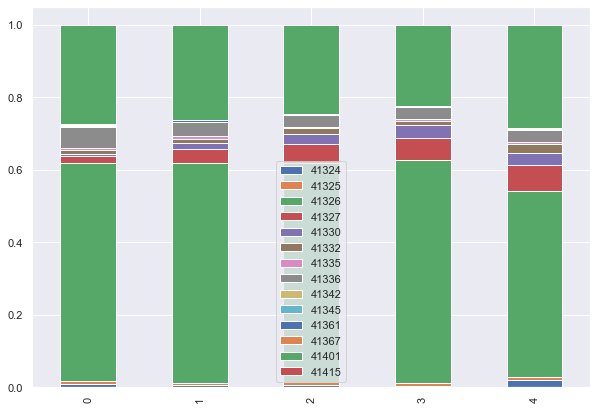

In [709]:
st = cat_distr_pairwise('AdoptionSpeed','State', df, frel=True)

### RescuerID

In order to extract some meaning from the 'RescuerID', we decided, as a first approach, to find out whether is frequent for rescuers to save and advertise multiple pets.

There are 5595 unique rescuers in the dataset
There are 3783 rescuers with only 1 webpage entry in the dataset
There are 1812 rescuers with more than 1 webpage entry in the dataset


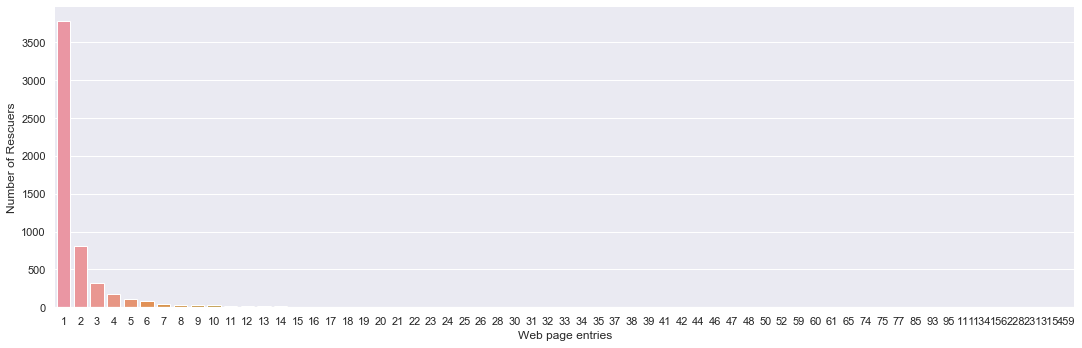

In [710]:
x = list(df['RescuerID'].unique())
y = list(df['RescuerID'])
z = []
t = {}
for i in x:
    z.append( y.count(i))

t['Rescuer'] = x
t['entries'] = z

e = pd.DataFrame(t)
print('There are {} unique rescuers in the dataset'.format(len(x)))
print('There are {} rescuers with only 1 webpage entry in the dataset'.format(z.count(1)))
print('There are {} rescuers with more than 1 webpage entry in the dataset'.format(len(x)-(z.count(1))))
ax11 = sns.catplot(x='entries', data=e, kind='count', height=5, aspect=3)
(ax11.set_axis_labels("Web page entries", "Number of Rescuers")
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

### VideoAmt

xxxxxxxxxxxx.

There are 14419 profiles with 0 videos
There are 574 profiles with more than 0 videos


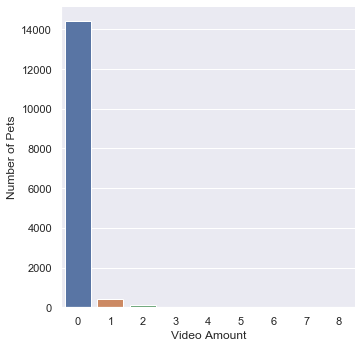

In [711]:
ax2 = sns.catplot(x='VideoAmt', data=df, kind='count')
(ax2.set_axis_labels("Video Amount", "Number of Pets"))
print('There are {} profiles with 0 videos'.format((list(df['VideoAmt'])).count(0)))
print('There are {} profiles with more than 0 videos'.format(len(df['VideoAmt'])-list(list(df['VideoAmt'])).count(0)))

Relative gain from AdoptionSpeed=0 (%):


,0,1,2,3,4,5,6,7,8
0,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,1.726,-37.8034,-24.8112,-33.657,inf,inf,inf,nan,nan
2,0.513799,-5.13062,5.76041,65.3522,inf,inf,inf,inf,nan
3,0.150955,-1.26842,29.6328,32.0527,inf,inf,inf,inf,inf
4,2.11754,-39.2903,-32.8807,42.9823,inf,inf,inf,nan,inf


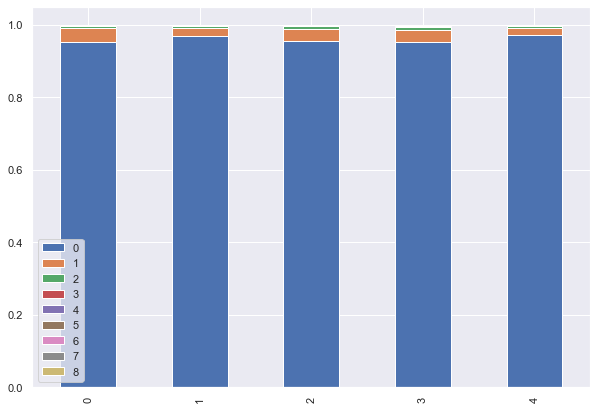

In [712]:
vid = cat_distr_pairwise('AdoptionSpeed','VideoAmt', df, frel=True)

### Photo Amt

xxxxxxxxxxxx.

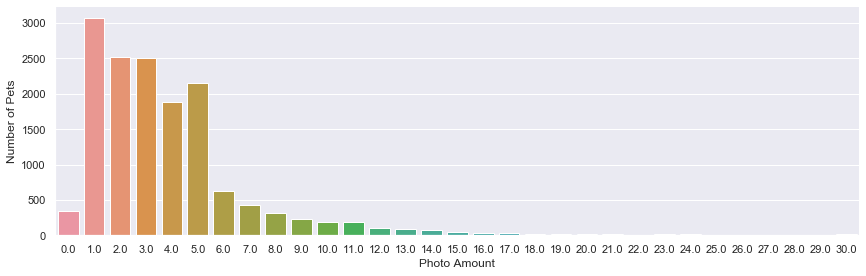

In [713]:
ax1 = sns.catplot(x='PhotoAmt', data=df, kind='count',height=4, aspect=3)
(ax1.set_axis_labels("Photo Amount", "Number of Pets"))

Relative gain from AdoptionSpeed=0 (%):


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,-81.2028,8.80259,-16.3918,-0.750809,25.0198,1.04556,7.03344,83.5491,28.2632,125.566,-0.485437,132.201,26.0518,85.7605,inf,-53.5599,inf,inf,nan,-73.4628,inf,nan,nan,inf,inf,inf,inf,-86.7314,inf,nan,inf
2,-100.158,6.25361,-19.0678,-9.88278,18.892,-4.78461,17.1021,122.8,50.9943,196.66,32.1873,159.042,30.7934,116.975,inf,10.4587,inf,inf,inf,-135.192,inf,inf,inf,inf,inf,inf,inf,-110.189,inf,nan,inf
3,-83.1678,-0.0906681,-26.6758,-19.3034,14.6549,-16.7112,42.3983,127.805,82.8584,238.461,91.7921,174.371,97.5447,187.3,inf,42.5892,inf,inf,inf,322.234,inf,inf,inf,inf,inf,inf,inf,37.5553,inf,inf,inf
4,303.291,32.3877,-9.1039,-4.18269,9.30375,-18.9753,1.95988,66.6299,28.3508,167.023,34.6738,124.7,30.8236,120.243,inf,-8.87913,inf,inf,inf,248.117,inf,inf,inf,inf,inf,inf,inf,-23.6193,inf,inf,inf


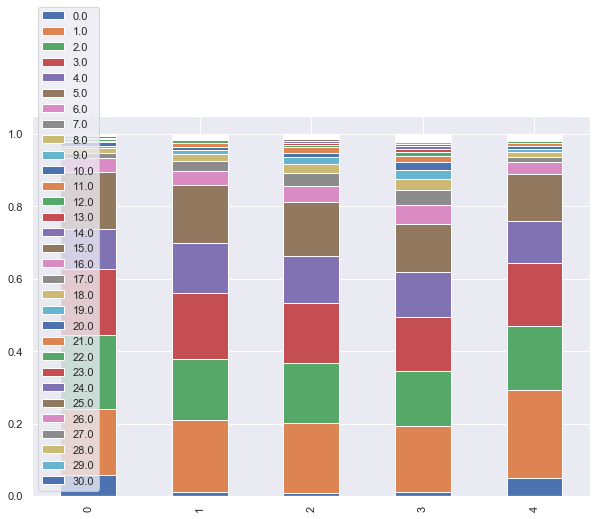

In [714]:
pht = cat_distr_pairwise('AdoptionSpeed','PhotoAmt', df, frel=True)

### Description

In order to extract some meaning from the 'Description', we decided, as a first approach, to partition this continuous feature into discrete values.

Since empty descriptions (size=0) probably have a direct influence in the adoption choice, it should be a category of its own. For that reason, we exclude empty descriptions from the discretization procces.

We consider that the discretization of the 'description sizes' based on the quantiles strategy is appropriate, since it is plausible to say that the ad writers define what a 'medium' size description is. In that sense, a 'medium' sized description would have the average word count. In analogy, the smallest and largest descriptions would correspond to the first and third quantiles.

The average descripton size: 62.953645034349364
According to this discretization, the bin edges should be:
[array([   0.,   28.,   65., 1257.])]


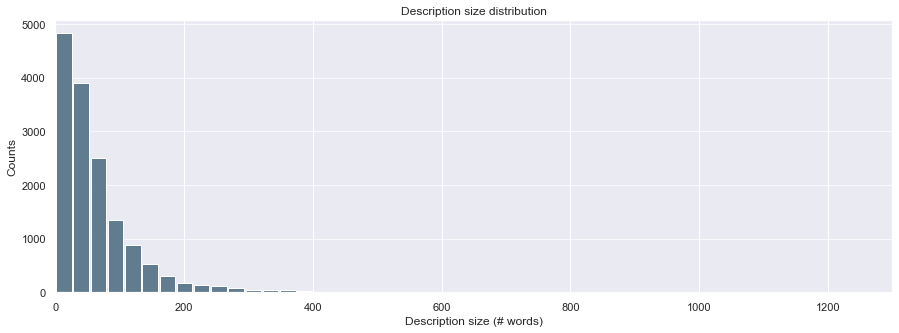

In [715]:
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
import statistics 

l=[]

# List descriptions' lengths (i.e. number of char)
for i in df['Description']:
    if type(i)!=str: # Some empty descriptions are type:float
        l.append(0)
    else:
        l.append(len(i.split()))

mean = statistics.mean(l)
print("The average descripton size:" , mean)

# Histogram
a1 = np.asarray(l)
nr_bins = 1 + 3.322*math.log(len(l),2) # Number of bins according to Sturges rule
a1 = pd.Series(a1)
a1.plot.hist(grid=True, bins = round(nr_bins), rwidth=0.9, color='#607c8e')
plt.title('Description size distribution')
plt.xlabel('Description size (# words)')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.xlim([0.0,1300])

# Discretization by quantile strategy:
a2 = np.asarray(l).reshape(-1,1) # Reshape data since we are working with just one feature
est = preprocessing.KBinsDiscretizer(n_bins=[3],encode='ordinal', strategy='quantile').fit(a2)
decp = est.transform(a2)

print("According to this discretization, the bin edges should be:")
print(est.bin_edges_) # how the data is distributed in the four bins

Based on these results, we present a new feature 'DescriptionSize' whose possible values include:
* 'Empty' for descriptions containing 0 words => 0
* 'Small' for descriptions containing 1-28 words => 1
* 'Medium' for descriptions containing 29-65 words => 2
* 'Large' for descriptions containing 66-1257 words => 3

Relative gain from AdoptionSpeed=0 (%):


,0,1,2,3
0,nan,nan,nan,nan
1,inf,-11.8336,1.79201,12.3552
2,inf,-8.69137,-1.26473,12.1513
3,inf,-11.3046,-3.84132,17.4745
4,inf,0.889801,-0.787307,3.39726


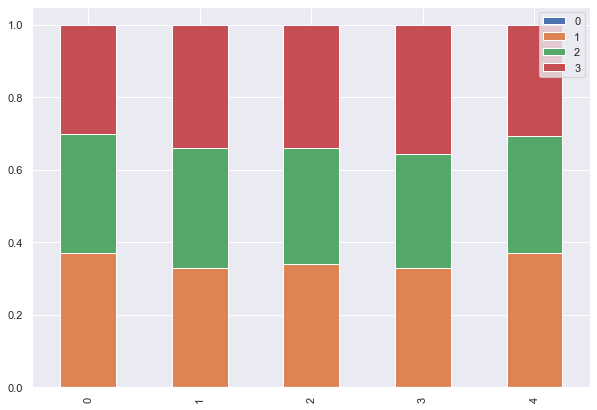

In [727]:
#Create new feature 'Description size'
d = []

for i in df['Description']:
    if type(i)!=str: # Some empty descriptions are type:float
        d.append(0)
    else:
        a= len(i.split())
        if a<29:
            d.append(1)
        elif a<66:
            d.append(2)
        else:
            d.append(3)
         
#df_processed = df_processed.drop("Description", axis=1)
#df_processed.insert(6,"DescriptionSize",d) ##INSERT IN DATAFRAME

desc = cat_distr_pairwise('AdoptionSpeed','DescriptionSize', df_processed, frel=True)

## Task 1 (Supervised Learning) - Predicting Adoption and Adoption Speed

## 1.1. Preprocessing Data for Classification

During our EDA we already preprocessed some of the features, for data visualization purposes. The result is the dataset df_processed.

#### BREEDS

The breeds1 and breeds2 feature are represented by numerical values that represent categorical values. These two features have also many different possible values that don't have any particular order relationship between them. Therefore, and to avoi the encoding of hundreds of values for both breeds1 and breeds2 we decided to create a new binary feature "PureBreed" which gives a value of 0 to the profiles whose pets are mixed a value of 1 to the profiles whose pets are pure breed.

#### RESCUERID

As a first approach we decided to create from the RescuerID a new binary feature (FrequentRescuer) that reflects those profiles who belong to frequent rescuers (profiles who have more than 1 pet advertised on the PetFinder website)

In [717]:
lista2 = []
y = list(df['RescuerID'])
for i in df['RescuerID']:
      if y.count(i)>1:
          lista2.append(float(1))
      else:
          lista2.append(float(0))
          
df.insert((df.columns.get_loc("RescuerID"))+1,'FrequentRescuer',lista2) ##INSERT IN DATAFRAME

#### DESCRIPTION

As a first approach we decided to create from the "Description" a new numerical feature (DescriptionLength) which reflects the number of characters in each profile's description. 

In [718]:
lista4=[]

for i in df['Description']:
    if type(i)!=str:
        lista4.append(float(0))
    else:
        lista4.append(float(len(i.split())))

df.insert((df.columns.get_loc("Description"))+1,'DescriptionLength',lista4) ##INSERT IN DATAFRAME

df = df.drop(['Name','RescuerID','PetID', 'Description', 'Breed1','Breed2'], axis=1)

KeyError: "['PetID'] not found in axis"

## 1.2. Learning Classifiers

#### ENCODING

Although most of the features are represented by numerical features they have a categorical meaning. Therefore and encoding was made for the following features:

In [ ]:
# ENCODING THE FOLLOWING FEATURES
## TYPE, GENDER, MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,State
encoder = OneHotEncoder()
df_encoded = encoder.fit_transform(df[['Type','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State']]).toarray()
column_name = encoder.get_feature_names(['Type','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'])
one_hot_encoded_frame =  pd.DataFrame(df_encoded, columns= column_name)

print(column_name) #encoded features names

print(one_hot_encoded_frame) #encoded dataframe without the non encoded features

In [ ]:
# INSERT THE NON ENCODED FEATURES IN THE DATAFRAME AGAIN
one_hot_encoded_frame.insert(2,'Name_cnt',df['Name_cnt']) ## NAME_CNT  
one_hot_encoded_frame.insert(3,'Age',df['Age']) ## AGE  
one_hot_encoded_frame.insert(4,'PureBreed',df['PureBreed']) ## PUREBREED    
one_hot_encoded_frame.insert(47,'Quantity',df['Quantity']) ## QUANTITY    
one_hot_encoded_frame.insert(48,'Fee',df['Fee']) ## FEE  
one_hot_encoded_frame.insert(63,'FrequentRescuer',df['FrequentRescuer']) ## FrequentRescuer  
one_hot_encoded_frame.insert(64,'VideoAmt',df['VideoAmt']) ## VideoAmt  
one_hot_encoded_frame.insert(65,'DescriptionLength',df['DescriptionLength']) ## DescriptionLength  
one_hot_encoded_frame.insert(66,'PhotoAmt',df['PhotoAmt']) ## PhotoAmt
one_hot_encoded_frame.insert(67,'AdoptionSpeed',df['AdoptionSpeed']) ## AdoptionSpeed

print(one_hot_encoded_frame) ## data frame for training

In [ ]:
nc = one_hot_encoded_frame.shape[1]
matrix = one_hot_encoded_frame.values # Convert dataframe to darray
examples = matrix [:, 0:nc-1] # get features 
target = matrix [:, nc-1] # get class (last columns)           
fnames = one_hot_encoded_frame.columns.values[0:nc-1] #get features names
tname = one_hot_encoded_frame.columns.values[nc-1] #get target name


### Predicting Adoption (binary classification task)

Since this is a binary task, the adoptionspeed had to be converted into a binary feature (0 - for profiles with adoptionspeed = 4; 1 for profiles with adoptionspeed < 4)

* DATA BALANCEMENT

In [ ]:
ex1 = examples
tgt1 = target 
fn1 = fnames
tn1 = tname

## change target feature to be binary
for i in range(len(tgt1)):
    if tgt1[i] < 4:
        tgt1[i]=float(1)
    else:
        tgt1[i]=float(0)

tn1 = 'Adoption' ##change target feature name

ex1 = ex1.astype(float)

print(tn1)
print(ex1)

In [ ]:
## split data frame into test and train sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(ex1, tgt1, random_state=0)

print(X_train_b.shape)
print(X_test_b.shape)

In [ ]:
print("Number of positives cases in the train set is: {}".format(np.count_nonzero(y_train_b == 1)))
print("Number of negative cases in the train set is: {}".format(np.count_nonzero(y_train_b == 0)))
print("Ratio positive to negative cases in the training set: {}".format((np.count_nonzero(y_train_b == 1))/(np.count_nonzero(y_train_b == 0))))

In [ ]:
print("Number of positives cases in the test set is: {}".format(np.count_nonzero(y_test_b == 1)))
print("Number of negative cases in the test set is: {}".format(np.count_nonzero(y_test_b == 0)))
print("Ratio positive to negative cases in the test set: {}".format((np.count_nonzero(y_test_b == 1))/(np.count_nonzero(y_test_b == 0))))

#### 1. KNN

In [ ]:
knn_b = neighbors.KNeighborsClassifier(n_neighbors=3) ## 3 neighbors for starters
knn_b

In [ ]:
knn_b = knn_b.fit(X_train_b, y_train_b)

y_train_pred_b_knn = knn_b.predict(X_train_b)

print("Accuracy on training set:",  knn_b.score(X_train_b, y_train_b))

In [ ]:
print(classification_report(y_train_b,y_train_pred_b_knn))

In [ ]:
cm_test = confusion_matrix(y_train_b, y_train_pred_b_knn)

annot_kws={'fontsize':20, 
           'fontstyle':'italic',  
           'color':"w",
           'alpha':1, 
           'rotation':"horizontal",
           'verticalalignment':'center'}

f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(cm_test.T, cmap="coolwarm", square=True, annot = True, fmt='d', annot_kws = annot_kws, cbar=False,
            xticklabels=(0,1),
            yticklabels=(0,1))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Train Set')

In [ ]:
y_test_pred_b_knn = knn_b.predict(X_test_b)

print("Accuracy on test set:",  knn_b.score(X_test_b, y_test_b))

In [ ]:
print(classification_report(y_test_b,y_test_pred_b_knn))

In [ ]:
cm_test = confusion_matrix(y_test_b, y_test_pred_b_knn)

annot_kws={'fontsize':20, 
           'fontstyle':'italic',  
           'color':"w",
           'alpha':1, 
           'rotation':"horizontal",
           'verticalalignment':'center'}

f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(cm_test.T, cmap="coolwarm", square=True, annot = True, fmt='d', annot_kws = annot_kws, cbar=False,
            xticklabels=(0,1),
            yticklabels=(0,1))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Test Set')

#### 2. NAIVE BAYES

In [ ]:
gnb_b = GaussianNB()
gnb_b

In [ ]:
gnb_b = GaussianNB()

#Train NAIVE BAYES ON THE TRAIN SET
gnb_b = gnb_b.fit(X_train_b, y_train_b)

print("Accuracy on training set:",  gnb_b.score(X_train_b, y_train_b))

# predictions for train set
y_train_pred_b_GNB = gnb_b.predict(X_train_b)

In [ ]:
print(classification_report(y_train_b,y_train_pred_b_GNB))

In [ ]:
cm_test = confusion_matrix(y_train_b, y_train_pred_b_GNB)

sns.heatmap(cm_test.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(0,1),
            yticklabels=(0,1))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Train Set')

In [ ]:
# predictions for test set
y_test_pred_b_GNB = gnb_b.predict(X_test_b)

print("Accuracy on test set:",  gnb_b.score(X_test_b, y_test_b))

In [ ]:
print(classification_report(y_test_b,y_test_pred_b_GNB))

In [ ]:
cm_test = confusion_matrix(y_test_b, y_test_pred_b_GNB)

sns.heatmap(cm_test.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(0,1),
            yticklabels=(0,1))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Test Set')

#### 3. DECISION TREES

In [ ]:
dtc_Gini = tree.DecisionTreeClassifier() # criterion = "Gini"

dtc_Gini = dtc_Gini.fit(ex1, tgt1)

dtc_Gini

In [ ]:
dot_data = tree.export_graphviz(dtc_Gini, out_file="pets.dot",
                                feature_names=fn1,
                                class_names=tn1,
                                filled=True, rounded=True,
                                special_characters=True)

#### 4. LOGISTIC REGRESSION

In [ ]:
logreg = LogisticRegression(solver='liblinear').fit(X_train_b, y_train_b)

## 1.3. Classification - Results and Discussion 

### Predicting AdoptionSpeed (Multiclass classification task)

*** Data balancement ***

In [ ]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(examples, df['AdoptionSpeed'], random_state=0) ### data split

In [ ]:
print("Number 0 adoption speed cases in the train set is: {}".format(np.count_nonzero(y_train_m == 0)))
print("Number 1 adoption speed cases in the train set is: {}".format(np.count_nonzero(y_train_m == 1)))
print("Number 2 adoption speed cases in the train set is: {}".format(np.count_nonzero(y_train_m == 2)))
print("Number 3 adoption speed cases in the train set is: {}".format(np.count_nonzero(y_train_m == 3)))
print("Number 4 adoption speed cases in the train set is: {}".format(np.count_nonzero(y_train_m == 4)))

In [ ]:
print("Number 0 adoption speed cases in the test set is: {}".format(np.count_nonzero(y_test_m == 0)))
print("Number 1 adoption speed cases in the test set is: {}".format(np.count_nonzero(y_test_m == 1)))
print("Number 2 adoption speed cases in the test set is: {}".format(np.count_nonzero(y_test_m == 2)))
print("Number 3 adoption speed cases in the test set is: {}".format(np.count_nonzero(y_test_m == 3)))
print("Number 4 adoption speed cases in the test set is: {}".format(np.count_nonzero(y_test_m == 4)))

#### 1. KNN

In [ ]:
knn_m = neighbors.KNeighborsClassifier(n_neighbors=3) ## 3 neighbors for starters
knn_m

In [ ]:
knn_m = knn_m.fit(X_train_m, y_train_m)

y_train_pred_m_KNN = knn_m.predict(X_train_m)

print("Accuracy on training set:",  knn_m.score(X_train_m, y_train_m))

In [ ]:
print(classification_report(y_train_m,y_train_pred_m_KNN))

In [ ]:
cm_test = confusion_matrix(y_train_m, y_train_pred_m_KNN)

annot_kws={'fontsize':15, 
           'fontstyle':'italic',  
           'color':"w",
           'alpha':1, 
           'rotation':"horizontal",
           'verticalalignment':'center'}

f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(cm_test.T, cmap="coolwarm", square=True, annot = True, fmt='d', annot_kws = annot_kws, cbar=False,
            xticklabels=(0,1,2,3,4),
            yticklabels=(0,1,2,3,4))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Train Set')

In [ ]:
y_test_pred_m_KNN = knn_m.predict(X_test_m)

print("Accuracy on test set:",  knn_m.score(X_test_m, y_test_m))

In [ ]:
print(classification_report(y_test_m,y_test_pred_m_KNN))

In [ ]:
cm_test = confusion_matrix(y_test_m, y_test_pred_m_KNN)

annot_kws={'fontsize':15, 
           'fontstyle':'italic',  
           'color':"w",
           'alpha':1, 
           'rotation':"horizontal",
           'verticalalignment':'center'}

f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(cm_test.T, cmap="coolwarm", square=True, annot = True, fmt='d', annot_kws = annot_kws, cbar=False,
            xticklabels=(0,1,2,3,4),
            yticklabels=(0,1,2,3,4))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Test Set')

#### 2. NAIVE BAYES

In [ ]:
gnb_m = GaussianNB()
gnb_m

In [ ]:
gnb_m = GaussianNB()

#Train NAIVE BAYES ON THE TRAIN SET
gnb_m = gnb_m.fit(X_train_m, y_train_m)

# predictions for train set
y_train_pred_m_GBN = gnb_m.predict(X_train_m)

print("Accuracy on training set:",  gnb_m.score(X_train_m, y_train_m))

In [ ]:
print(classification_report(y_train_m,y_train_pred_m_GBN))

In [ ]:
cm_test = confusion_matrix(y_train_m, y_train_pred_m_GBN)

sns.heatmap(cm_test.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(0,1,2,3,4),
            yticklabels=(0,1,2,3,4))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Train Set')

In [ ]:
# predictions for test set
y_test_pred_m_GBB = gnb_m.predict(X_test_m)

print("Accuracy on test set:",  gnb_m.score(X_test_m, y_test_m))

In [ ]:
print(classification_report(y_test_m,y_test_pred_m_GBB))

In [ ]:
cm_test = confusion_matrix(y_test_m, y_test_pred_m_GBB)

sns.heatmap(cm_test.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=(0,1,2,3,4),
            yticklabels=(0,1,2,3,4))
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix - Test Set')

#### 3. DECISION TREES

#### 3. LOGISTIC REGRESSION

## Task 2 (Unsupervised Learning) - Charactering Adopted Pets and Adoption Speed

In this task you should **use unsupervised learning algorithms and try to characterize pets that were actually adopted and their adoption speed**. You can use:
* **Association rule mining** to find **associations between the features and the target Adoption/AdoptionSpeed**.
* **Clustering algorithms to find similar groups of pets**. Is it possible to find groups of pets with the same/similar adoption speed.
* **Be creative and define your own unsupervised analysis!** What would it be interesting to find out ?

## 2.1. Preprocessing Data for Association Rule Mining

...

## 2.2. Finding Associations

...

## 2.3 Association Rules - Results and Discussion 

...

## 2.4. Preprocessing Data for Clustering

...

## 2.5. Finding Groups

...

## 2.6. Clustering - Results and Discussion 

...

## 3. Final Comments and Conclusions

...